In [1]:
#necessary module
import os ; import sys
sys.path.append(os.getcwd()+"/Equantum")
#path to data
datapath="/scratch/zhaoyuha/Datas/EQuantum_data/topgate/"
setuppath="setup/dotgate/"
from sites import Site
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from fsc import FSC
import scipy.linalg as sl
import scipy.constants as sc
import importlib
import poissonsolver as psolver
import kwant
import scipy.io as sio
%matplotlib widget

from EQsystem import System

In [37]:
import fsc
importlib.reload(fsc)
from fsc import FSC

import EQsystem
importlib.reload(EQsystem)
from EQsystem import System
#test module
import solvers
importlib.reload(solvers)
from solvers import local_solver

from scipy.interpolate import interp1d
from scipy.optimize import brentq

In [36]:
import qbuilder
importlib.reload(qbuilder)

<module 'qbuilder' from '/scratch/zhaoyuha/EQuantum/EQuantum/Equantum/qbuilder.py'>

## Define system

In [ ]:
def density_function(r):
        spacing0 = 0.001 # spacing at r=0
        k = 0.3  # spacing increases by 0.05 per unit distance
        return spacing0 + np.exp(r/k)

In [4]:
geoparams={"lattice_type": "square",   # or honeycomb_lattice, etc.
"box_size": ((-0.5, 0.5), (-0.5, 0.5), (-0.08, 0.08)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

In [119]:
geoparams={"lattice_type": "honeycomb",   # or honeycomb_lattice, etc.
"box_size": ((-0.5, 0.5), (-0.5, 0.5), (-0.08, 0.08)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

## Initialize System

In [120]:
syst=System(geoparams)
syst.export_sites(filename=setuppath+"sites.json")

Generated 2 points in 3D.


QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 5)

While executing:  | qhull v Qbb Qc Qz
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1812059260  voronoi  Qbbound-last  Qcoplanar-keep  Qz-infinity-point
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0


In [7]:
config_file=setuppath+"001_hc.json"
syst=System(geoparams,config_file=config_file,ifqsystem=True,quantum_builder="default")

Generated 15915 points in 3D.
Voronoi cells have been created.
0 sites have been removed from the system.
Quantum system is generated using default.
EQsystem is successfully initialized.


In [93]:
qparams={'Ufunc': lambda x:0,'phi':0.02}
fsc=FSC(syst,ifinitial=False,params=qparams)

The quantum problem has been initialized.


In [99]:
fsc.update_BC(syst,'gate','potential',30)
fsc.update_BC(syst,'backgate','potential',-50,ifinitial=True)

The poisson problem has been initialized.


In [21]:
fsc.phi_to_B()

12.73455390985509

## Check the Spectrum

In [96]:
ltest=qbuilder.update_ildos(fsc,syst,delta=fsc.t/20,w=np.linspace(-fsc.bandwidth,fsc.bandwidth,2000))

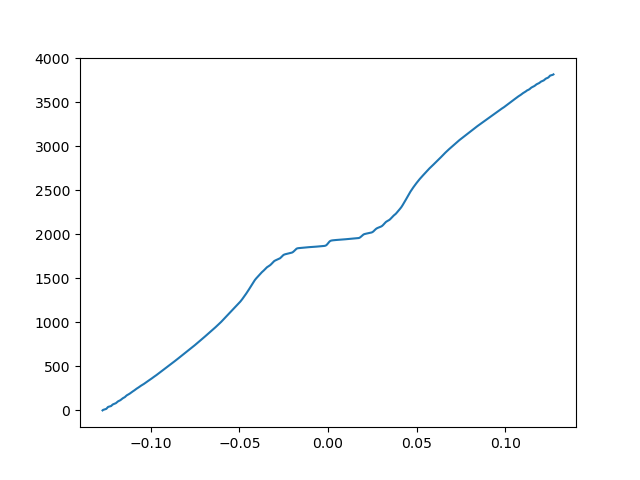

In [97]:
plt.figure()
#plt.plot(ltest[1][0],ltest[1][1])
plt.plot(ltest[1][0],[np.sum(ltest[1][1][:idx]) for idx in range(len(ltest[1][0]))])
plt.show()

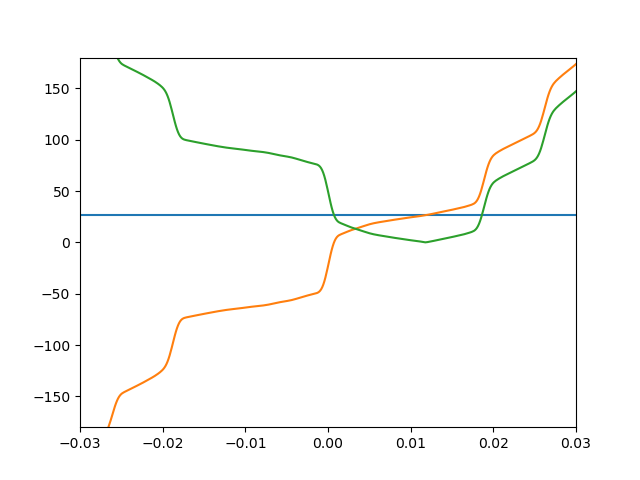

In [100]:
sidx=0
ni=fsc.ni[fsc.Qprime][sidx]
Ci=fsc.Ci[sidx]
ildos=fsc.ildos[sidx]
Ui=fsc.Ui[fsc.Qprime][sidx]

x_dis=ildos[0]-Ui
y_dis=ildos[1]
ildos_dis=[np.sum(y_dis[:idx]) for idx in range(len(x_dis))]
ildos_dis=ildos_dis-fsc.max_fill/2
ildos_iterp=interp1d(x_dis,ildos_dis,kind='linear',fill_value='exptrapolate')
def dn_for_Ci(dU):
    return -dU*Ci+ni
def diff(dU):
    return np.abs(dn_for_Ci(dU)-ildos_iterp(dU))

dUs=np.linspace(-5,5,200)*fsc.t
plt.figure()
plt.plot(x_dis,[dn_for_Ci(dU) for dU in x_dis])
plt.plot(x_dis,[ildos_iterp(dU) for dU in x_dis])
plt.plot(x_dis,[diff(dU) for dU in x_dis])
plt.ylim((-180,180))
plt.xlim((-0.03,0.03))
#plt.plot(x_dis,ildos_dis)
#plt.plot(fsc.ildos[0][0],fsc.ildos[0][1])
plt.show()

In [15]:
Htest=fsc.qsystem.H.toarray()
pot=np.diagonal(Htest)

In [16]:
ev=np.sort(sl.eigvals(Htest))

In [17]:
ildos=qbuilder.update_ildos(fsc,syst,delta=fsc.t/20,w=np.linspace(-2.9*fsc.t,2.9*fsc.t,2000),
npol_scale=6)

/scratch/zhaoyuha/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


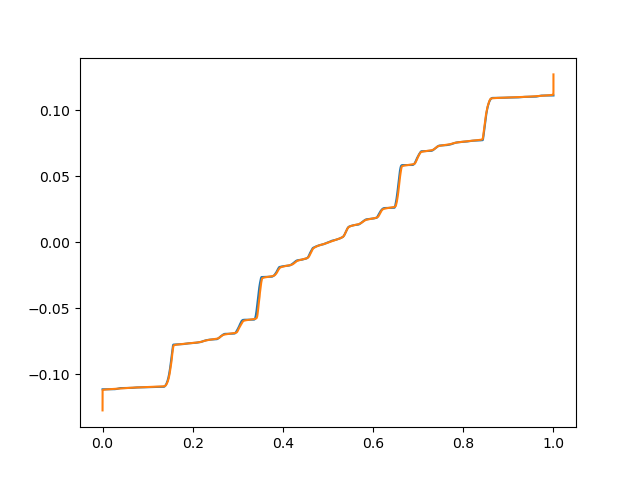

In [20]:
nden=np.array([np.sum(ildos[0][1][:idx])for idx,ee in enumerate(ildos[0][0])])
plt.figure()
plt.plot(np.linspace(0,1,len(ev)),ev)
plt.plot(nden/nden[-1],ildos[0][0])
plt.show()

## Plot System

/scratch/zhaoyuha/EQuantum/EQuantum/Equantum/EQsystem.py:241: RuntimeWarning: divide by zero encountered in true_divide
  alphamap=np.abs(prop_values/(1.5*(np.max(prop_values)-np.min(prop_values))))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


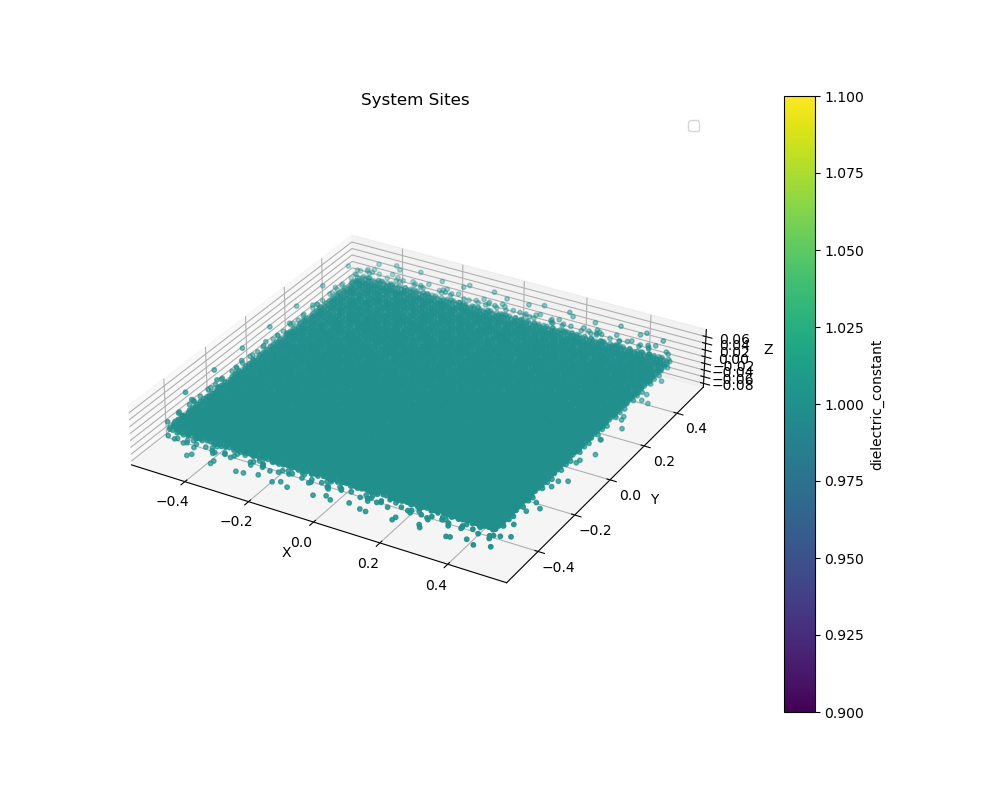

In [18]:
syst.plot_geometry("dielectric_constant")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


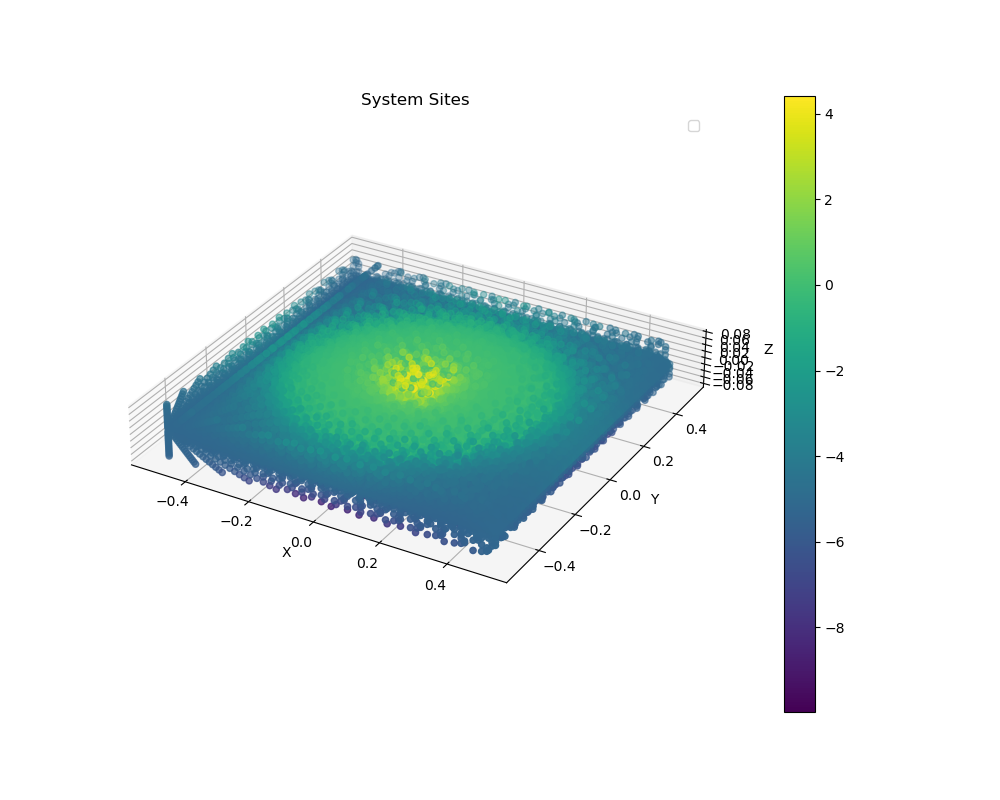

In [29]:
indicate=np.zeros(len(fsc.sites))
indicate[fsc.D_indices]=1
fsc.plot_full(fsc.Ui)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


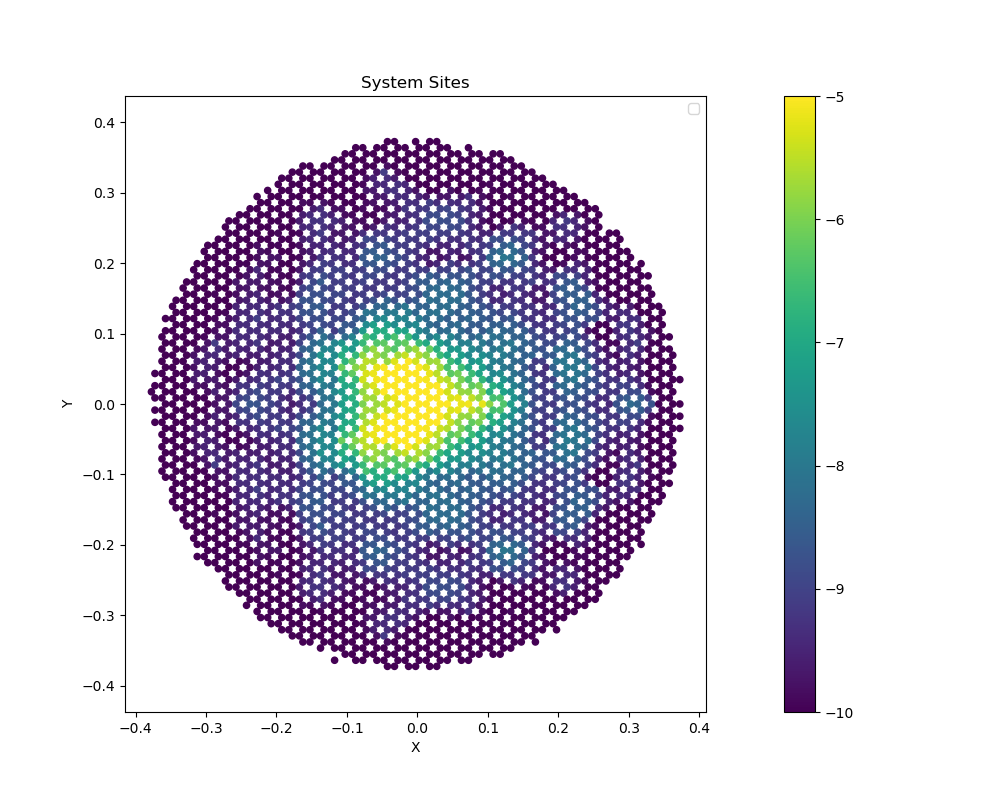

In [116]:
indicate=np.zeros(len(fsc.Qsites))
#indicate[1335]=1
plotdata=fsc.ni[fsc.Qsites]
#plotdata=dUdn[1]
#plotdata=pot
fsc.plot_qsystem(-plotdata,vmin=-10,vmax=-5)

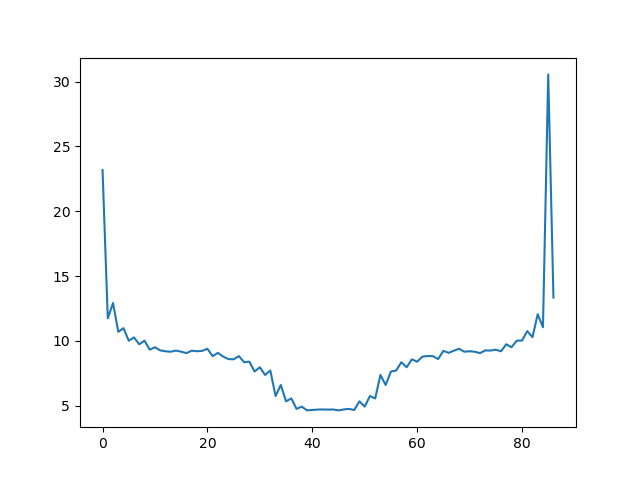

In [108]:
cut_idx=[idx for idx in range(len(fsc.sites)) if np.abs(fsc.sites[idx].coordinates[0])<0.01 and fsc.sites[idx].material=='Qsystem']
plt.figure()
plt.plot(fsc.ni[cut_idx])
plt.show()

## Solve FSC

In [102]:
fsc.solve(syst,save=datapath+"test")

-0.06362207771967553 0.014304399813791032
9.435689946630935e-10 -2.1214629739377878e-10
The iteration has been conducted for  [0, 0, 0] times.
{'ni_error': [1, -2.5144685440156356e-15, 0.003057717087326132], 'Qprime_len': [3402, 3402, 3402], 'ildos_error': [1]}
7.947286627613473e-18 0.0
The iteration has been conducted for  [0, 1, 0] times.
{'ni_error': [1, -2.5144685440156356e-15, 0.003057717087326132, 0.0], 'Qprime_len': [3402, 3402, 3402, 3402], 'ildos_error': [1]}
-5.930501180200984e-18 0.0


In [110]:
data=sio.loadmat(datapath+"test")
Uis=data['Uis']
nis=data['nis']

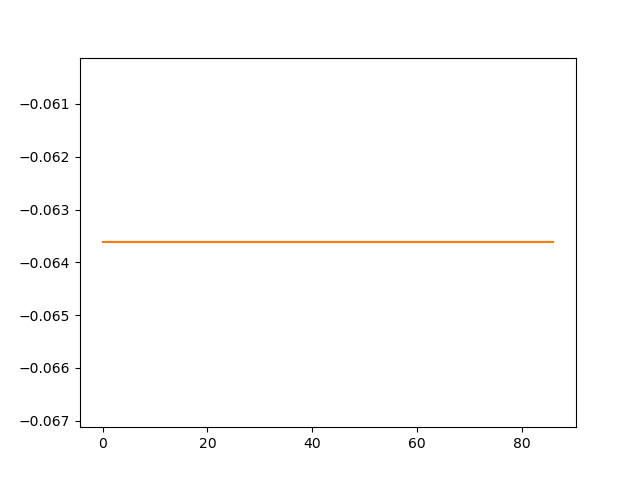

In [112]:
cut_idx=[idx for idx in range(len(fsc.sites)) if np.abs(fsc.sites[idx].coordinates[0])<0.01 and fsc.sites[idx].material=='Qsystem']
plt.figure()
for Uii in Uis:
    plt.plot(Uii[cut_idx])
plt.show()